In [1]:
import sys
sys.path.append('/Users/omarschall/vanilla-rtrl/')
import numpy as np
from network import *
from simulation import *
from gen_data import *
try:
    import matplotlib.pyplot as plt
except ModuleNotFoundError:
    pass
from optimizers import *
from analysis_funcs import *
from learning_algorithms import *
from functions import *
from itertools import product
import os
import pickle
from copy import deepcopy
from scipy.ndimage.filters import uniform_filter1d
from sklearn import linear_model
from state_space import *
from dynamics import *
import multiprocessing as mp
from functools import partial
from sklearn.cluster import DBSCAN
from netcomp.distance import netsimile

In [2]:
from pyemd import emd
from pdb import set_trace
from sklearn.cross_decomposition import CCA

In [3]:
%matplotlib notebook

In [4]:
np.random.seed(0)
task = Flip_Flop_Task(3, 0.05, tau_task=1)
N_train = 100000
N_test = 10000
data = task.gen_data(N_train, N_test)

In [5]:
def wasserstein_distance(checkpoint_1, checkpoint_2):
    
    cluster_means_1 = checkpoint_1['cluster_means']
    fixed_points_1 = checkpoint_1['fixed_points']
    cluster_labels_1 = checkpoint_1['cluster_labels']
    cluster_weights_1 = []
    for j in range(cluster_means_1.shape[0]):
        cluster_weights_1.append(len(np.where(cluster_labels_1 == j)[0]))
    cluster_weights_1 = np.array(cluster_weights_1)
    
    cluster_means_2 = checkpoint_2['cluster_means']
    fixed_points_2 = checkpoint_2['fixed_points']
    cluster_labels_2 = checkpoint_2['cluster_labels']
    cluster_weights_2 = []
    for j in range(cluster_means_2.shape[0]):
        cluster_weights_2.append(len(np.where(cluster_labels_2 == j)[0]))
    cluster_weights_2 = np.array(cluster_weights_2)
    
    hist1 = np.concatenate([cluster_weights_1, np.zeros_like(cluster_weights_2)], axis=0).astype(np.float64)
    hist2 = np.concatenate([np.zeros_like(cluster_weights_1), cluster_weights_2], axis=0).astype(np.float64)
    N = len(cluster_weights_1) + len(cluster_weights_2)
    
    combined_means = np.concatenate([cluster_means_1, cluster_means_2], axis=0)
    
    distances = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            distances[i, j] = norm(combined_means[i] - combined_means[j])
            
    #set_trace()
    
    return emd(hist1, hist2, distances)

In [7]:
data_path = '/Users/omarschall/cluster_results/vanilla-rtrl/rflo_sparsity_analyze/'

In [8]:
def process_results(data_path, N_jobs, rflo_checkpoints={}, bptt_checkpoints={}):
    
    for i in range(N_jobs):

        file_path = os.path.join(data_path, 'result_{}'.format(i))
    
        try:
            with open(file_path, 'rb') as f:
                result = pickle.load(f)
        except FileNotFoundError:
            continue
            
        if result['config']['algorithm'] == 'RFLO':
            rflo_checkpoints.update(result)
                
        if result['config']['algorithm'] == 'E-BPTT':
            bptt_checkpoints.update(result)
                
    return rflo_checkpoints, bptt_checkpoints

In [10]:
def process_all_results(data_path, N_jobs, rflo_checkpoints={}):
    
    for i in range(N_jobs):

        file_path = os.path.join(data_path, 'result_{}'.format(i))
    
        try:
            with open(file_path, 'rb') as f:
                result = pickle.load(f)
        except FileNotFoundError:
            continue
            
        rflo_checkpoints.update(result)
            
    return rflo_checkpoints

In [11]:
rflo_checkpoints = process_all_results(data_path, 100, rflo_checkpoints={})

In [9]:
rflo_checkpoints, bptt_checkpoints = process_results(data_path, 202, rflo_checkpoints={}, bptt_checkpoints={})

KeyError: 'algorithm'

In [16]:
rflo_checkpoints.keys()

dict_keys(['checkpoint_0', 'checkpoint_100', 'checkpoint_200', 'checkpoint_300', 'checkpoint_400', 'checkpoint_500', 'checkpoint_600', 'checkpoint_700', 'checkpoint_800', 'checkpoint_900', 'i_job', 'config', 'checkpoint_1000', 'checkpoint_1100', 'checkpoint_1200', 'checkpoint_1300', 'checkpoint_1400', 'checkpoint_1500', 'checkpoint_1600', 'checkpoint_1700', 'checkpoint_1800', 'checkpoint_1900', 'checkpoint_2000', 'checkpoint_2100', 'checkpoint_2200', 'checkpoint_2300', 'checkpoint_2400', 'checkpoint_2500', 'checkpoint_2600', 'checkpoint_2700', 'checkpoint_2800', 'checkpoint_2900', 'checkpoint_3000', 'checkpoint_3100', 'checkpoint_3200', 'checkpoint_3300', 'checkpoint_3400', 'checkpoint_3500', 'checkpoint_3600', 'checkpoint_3700', 'checkpoint_3800', 'checkpoint_3900', 'checkpoint_4000', 'checkpoint_4100', 'checkpoint_4200', 'checkpoint_4300', 'checkpoint_4400', 'checkpoint_4500', 'checkpoint_4600', 'checkpoint_4700', 'checkpoint_4800', 'checkpoint_4900', 'checkpoint_5000', 'checkpoint_5

In [12]:
i_rflo = sorted([int(k.split('_')[-1]) for k in rflo_checkpoints.keys() if 'checkpoint' in k])

In [34]:
i_rflo = sorted([int(k.split('_')[-1]) for k in rflo_checkpoints.keys() if 'checkpoint' in k])
i_bptt = sorted([int(k.split('_')[-1]) for k in bptt_checkpoints.keys() if 'checkpoint' in k])

In [52]:
rflo_distances = []
for i in i_rflo[:-1]:
    
    try:
        checkpoint_1 = rflo_checkpoints['checkpoint_{}'.format(i)]
        checkpoint_2 = rflo_checkpoints['checkpoint_{}'.format(i + 100)]
    except KeyError:
        continue
        
    #rflo_distances.append(netsimile(checkpoint_1['adjacency_matrix'],
    #                                checkpoint_2['adjacency_matrix']))
    
    #rflo_distances.append((checkpoint_1['V'] * checkpoint_2['V']).sum())
    
    #cca = CCA(n_components=3)
    #cca.fit(checkpoint_1['V'], checkpoint_2['V'])
    #distance = cca.score(checkpoint_1['V'], checkpoint_2['V'])
    distance = SVCCA_distance(checkpoint_1, checkpoint_2, data)
    rflo_distances.append(distance)

/Users/omarschall/opt/anaconda3/envs/netcomp/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/Users/omarschall/opt/anaconda3/envs/netcomp/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (th

/Users/omarschall/opt/anaconda3/envs/netcomp/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/Users/omarschall/opt/anaconda3/envs/netcomp/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (th

/Users/omarschall/opt/anaconda3/envs/netcomp/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/Users/omarschall/opt/anaconda3/envs/netcomp/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (th

/Users/omarschall/opt/anaconda3/envs/netcomp/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/Users/omarschall/opt/anaconda3/envs/netcomp/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (th

/Users/omarschall/opt/anaconda3/envs/netcomp/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/Users/omarschall/opt/anaconda3/envs/netcomp/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (th

/Users/omarschall/opt/anaconda3/envs/netcomp/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/Users/omarschall/opt/anaconda3/envs/netcomp/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (th

/Users/omarschall/opt/anaconda3/envs/netcomp/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/Users/omarschall/opt/anaconda3/envs/netcomp/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (th

/Users/omarschall/opt/anaconda3/envs/netcomp/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/Users/omarschall/opt/anaconda3/envs/netcomp/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (th

/Users/omarschall/opt/anaconda3/envs/netcomp/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/Users/omarschall/opt/anaconda3/envs/netcomp/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (th

/Users/omarschall/opt/anaconda3/envs/netcomp/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/Users/omarschall/opt/anaconda3/envs/netcomp/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (th

/Users/omarschall/opt/anaconda3/envs/netcomp/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/Users/omarschall/opt/anaconda3/envs/netcomp/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (th

/Users/omarschall/opt/anaconda3/envs/netcomp/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/Users/omarschall/opt/anaconda3/envs/netcomp/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (th

/Users/omarschall/opt/anaconda3/envs/netcomp/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/Users/omarschall/opt/anaconda3/envs/netcomp/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (th

/Users/omarschall/opt/anaconda3/envs/netcomp/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/Users/omarschall/opt/anaconda3/envs/netcomp/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (th

/Users/omarschall/opt/anaconda3/envs/netcomp/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/Users/omarschall/opt/anaconda3/envs/netcomp/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (th

KeyboardInterrupt: 

In [44]:
bptt_distances = []
for i in i_bptt[:-1]:
    
    try:
        checkpoint_1 = bptt_checkpoints['checkpoint_{}'.format(i)]
        checkpoint_2 = bptt_checkpoints['checkpoint_{}'.format(i + 100)]
    except KeyError:
        continue
        
    #bptt_distances.append(netsimile(checkpoint_1['adjacency_matrix'],
    #                                checkpoint_2['adjacency_matrix']))
    
    #bptt_distances.append((checkpoint_1['V'] * checkpoint_2['V']).sum())
    
    cca = CCA(n_components=3)
    cca.fit(checkpoint_1['V'], checkpoint_2['V'])
    distance = cca.score(checkpoint_1['V'], checkpoint_2['V'])
    bptt_distances.append(distance)

/Users/omarschall/opt/anaconda3/envs/netcomp/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/Users/omarschall/opt/anaconda3/envs/netcomp/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (th

/Users/omarschall/opt/anaconda3/envs/netcomp/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/Users/omarschall/opt/anaconda3/envs/netcomp/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (th

/Users/omarschall/opt/anaconda3/envs/netcomp/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/Users/omarschall/opt/anaconda3/envs/netcomp/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (th

/Users/omarschall/opt/anaconda3/envs/netcomp/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/Users/omarschall/opt/anaconda3/envs/netcomp/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (th

/Users/omarschall/opt/anaconda3/envs/netcomp/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/Users/omarschall/opt/anaconda3/envs/netcomp/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (th

/Users/omarschall/opt/anaconda3/envs/netcomp/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/Users/omarschall/opt/anaconda3/envs/netcomp/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (th

/Users/omarschall/opt/anaconda3/envs/netcomp/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/Users/omarschall/opt/anaconda3/envs/netcomp/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (th

/Users/omarschall/opt/anaconda3/envs/netcomp/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/Users/omarschall/opt/anaconda3/envs/netcomp/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (th

/Users/omarschall/opt/anaconda3/envs/netcomp/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/Users/omarschall/opt/anaconda3/envs/netcomp/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (th

/Users/omarschall/opt/anaconda3/envs/netcomp/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/Users/omarschall/opt/anaconda3/envs/netcomp/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:96: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
/Users/omarschall/opt/anaconda3/envs/netcomp/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consis

/Users/omarschall/opt/anaconda3/envs/netcomp/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/Users/omarschall/opt/anaconda3/envs/netcomp/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (th

/Users/omarschall/opt/anaconda3/envs/netcomp/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/Users/omarschall/opt/anaconda3/envs/netcomp/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (th

/Users/omarschall/opt/anaconda3/envs/netcomp/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/Users/omarschall/opt/anaconda3/envs/netcomp/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (th

/Users/omarschall/opt/anaconda3/envs/netcomp/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/Users/omarschall/opt/anaconda3/envs/netcomp/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (th

/Users/omarschall/opt/anaconda3/envs/netcomp/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/Users/omarschall/opt/anaconda3/envs/netcomp/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (th

/Users/omarschall/opt/anaconda3/envs/netcomp/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/Users/omarschall/opt/anaconda3/envs/netcomp/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (th

In [42]:
rflo_distances[0]

CCA(copy=True, max_iter=500, n_components=3, scale=True, tol=1e-06)

In [ ]:
rflo_norms = [sum([norm(v) for v in rflo_checkpoints['checkpoint_{}'.format(i)]['optimizer'].vel][:3]) for i in i_rflo]
bptt_norms = [sum([norm(v) for v in bptt_checkpoints['checkpoint_{}'.format(i)]['optimizer'].vel][:3]) for i in i_bptt]

In [ ]:
rflo_norms = [norm(rflo_checkpoints['checkpoint_{}'.format(i)]['learn_alg'].rec_grads) for i in i_rflo]
bptt_norms = [norm(bptt_checkpoints['checkpoint_{}'.format(i)]['learn_alg'].rec_grads) for i in i_bptt]

In [ ]:
rflo_dW = [norm(rflo_checkpoints['checkpoint_{}'.format(i)]['rnn'].W_rec - 
                rflo_checkpoints['checkpoint_{}'.format(i - 100)]['rnn'].W_rec) for i in i_rflo[1:]]
bptt_dW = [norm(bptt_checkpoints['checkpoint_{}'.format(i)]['rnn'].W_rec - 
                bptt_checkpoints['checkpoint_{}'.format(i - 100)]['rnn'].W_rec) for i in i_bptt[1:]]

In [ ]:
rflo_test_loss = [rflo_checkpoints['checkpoint_{}'.format(i)]['test_loss'] for i in i_rflo]
bptt_test_loss = [bptt_checkpoints['checkpoint_{}'.format(i)]['test_loss'] for i in i_bptt]

In [47]:
def SVCCA_distance(checkpoint_1, checkpoint_2, data, R=3):
    """Compute the singular-value canonical correlation analysis distance
    between two different networks."""
    
    A_1 = get_test_sim_data(checkpoint_1, data)
    A_2 = get_test_sim_data(checkpoint_1, data)
    
    cca = CCA(n_components=R)
    cca.fit(A_1, A_2)
    
    return cca.score(A_1, A_2)

In [50]:
SVCCA_distance(checkpoint_1, checkpoint_2, data)

/Users/omarschall/opt/anaconda3/envs/netcomp/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


0.421456987516171

<IPython.core.display.Javascript object>


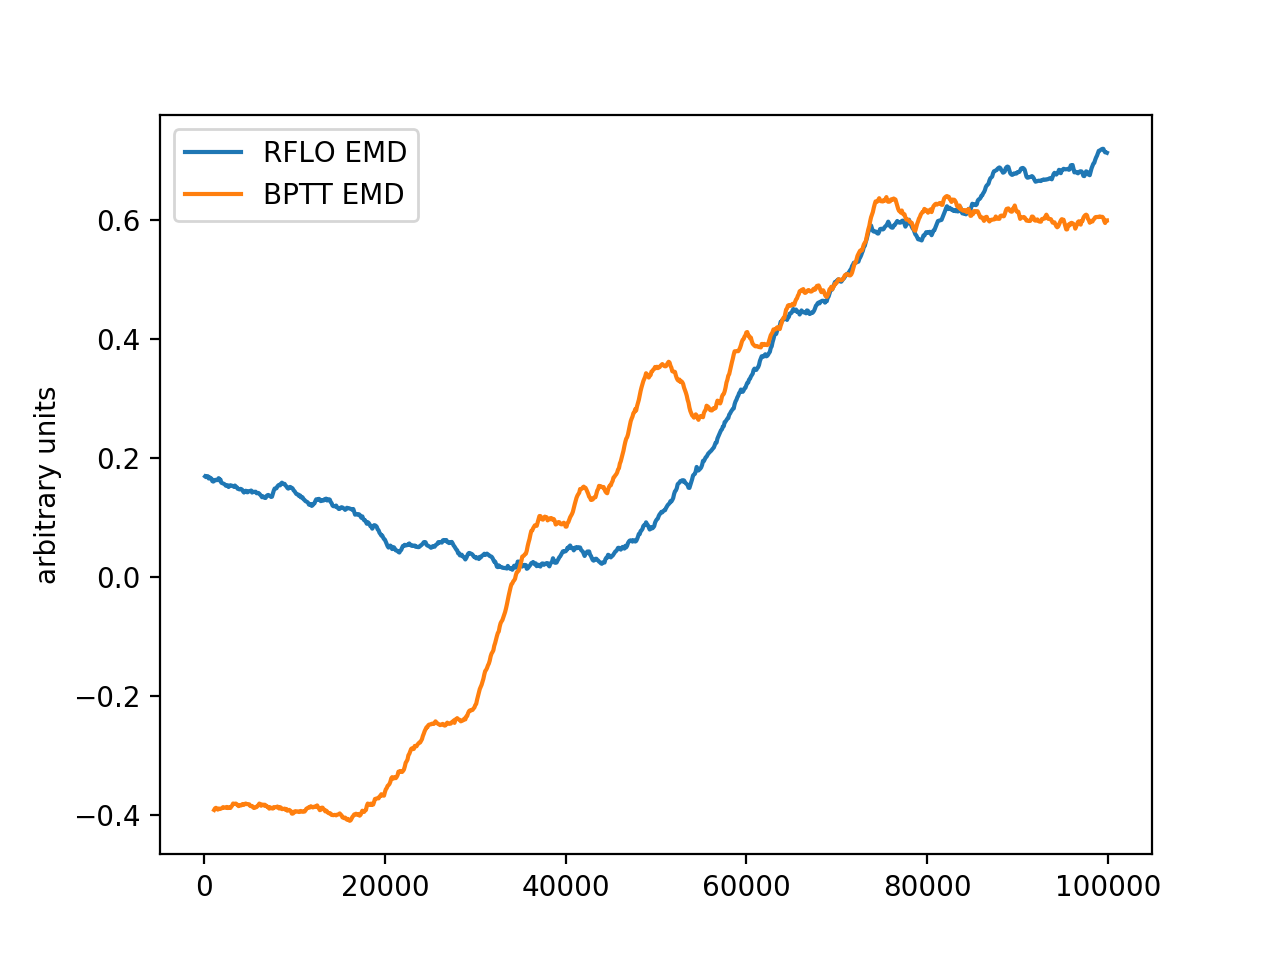

Text(0, 0.5, 'arbitrary units')

In [46]:
plt.figure()
plt.plot(i_rflo[1:], uniform_filter1d(rflo_distances, 200))
plt.plot(i_bptt[1:], uniform_filter1d(bptt_distances, 200))
y_max = np.amax(uniform_filter1d(bptt_distances, 200))
#rflo_dW_scaled = rflo_dW / np.amax(rflo_dW) * y_max
#bptt_dW_scaled = bptt_dW / np.amax(rflo_dW) * y_max
#plt.plot(i_rflo[1:], uniform_filter1d(rflo_dW_scaled, 200), 'C0', linestyle='--')
#plt.plot(i_bptt[1:], uniform_filter1d(bptt_dW_scaled, 200), 'C1', linestyle='--')
#rflo_test_loss_scaled = rflo_test_loss / np.amax(rflo_test_loss) * y_max
#bptt_test_loss_scaled = bptt_test_loss / np.amax(rflo_test_loss) * y_max
#plt.plot(i_rflo, uniform_filter1d(rflo_test_loss_scaled, 200), 'C0', linestyle='--')
#plt.plot(i_bptt, uniform_filter1d(bptt_test_loss_scaled, 200), 'C1', linestyle='--')
plt.legend(['RFLO EMD', 'BPTT EMD', 'RFLO dW', 'BPTT dW'])
plt.ylabel('arbitrary units')

<IPython.core.display.Javascript object>


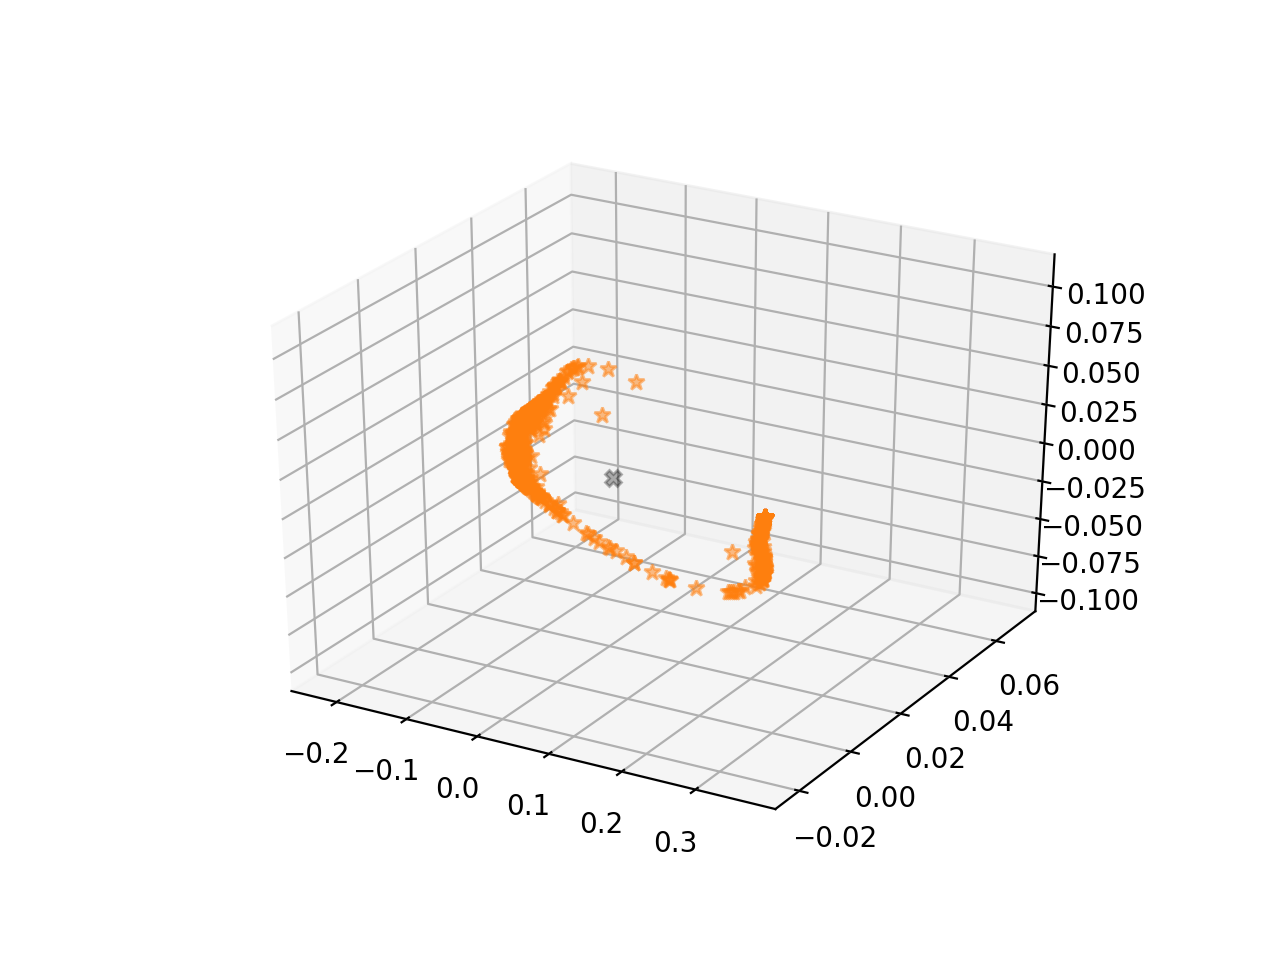

<IPython.core.display.Javascript object>


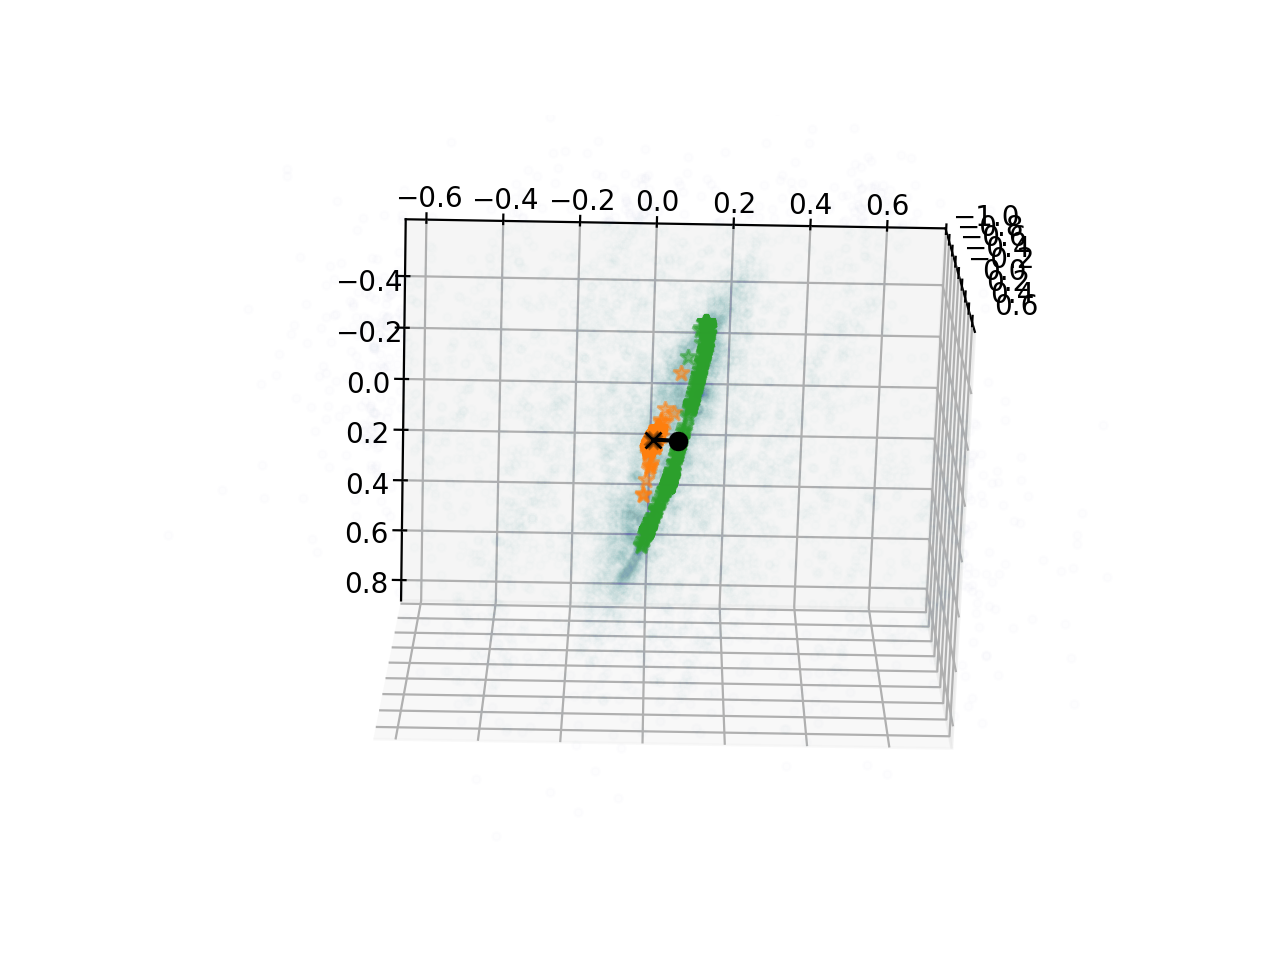

In [46]:
### RFLO ###

#Checkpoint to base axes on
i_checkpoint = 24000
checkpoint = rflo_checkpoints['checkpoint_{}'.format(i_checkpoint)]
transform = partial(np.dot, b=checkpoint['V'])
ssa = State_Space_Analysis(checkpoint, data, transform=transform)
ssa_2 = State_Space_Analysis(checkpoint, data, transform=transform)

#Plotting checkpoing
i_checkpoint = 24200
checkpoint = rflo_checkpoints['checkpoint_{}'.format(i_checkpoint)]
plot_checkpoint_results(checkpoint, data, ssa=ssa, plot_cluster_means=True, eig_norm_color=False,
                        plot_test_points=False,
                        plot_fixed_points=True,
                        plot_graph_structure=True)

i_checkpoint = i_checkpoint + 100
checkpoint = rflo_checkpoints['checkpoint_{}'.format(i_checkpoint)]
plot_checkpoint_results(checkpoint, data, ssa=ssa_2, plot_cluster_means=True, eig_norm_color=False,
                        plot_test_points=True,
                        plot_fixed_points=True,
                        plot_graph_structure=True)

#rnn = checkpoint['rnn']
#test_sim = Simulation(rnn)
#test_sim.run(data,
#              mode='test',
#              monitors=['rnn.loss_', 'rnn.y_hat'],
#              verbose=False)

#plt.figure()
#plt.plot(test_sim.mons['rnn.y_hat'][:, 0])
#plt.plot(data['test']['Y'][:, 0])
#plt.xlim([0, 1000])

In [ ]:
plt.figure()
plt.imshow(checkpoint['adjacency_matrix'])

In [ ]:
### BPTT ###                                                              

#Checkpoint to base axes on
i_checkpoint = 20000
checkpoint = bptt_checkpoints['checkpoint_{}'.format(i_checkpoint)]
transform = partial(np.dot, b=checkpoint['V'])
ssa = State_Space_Analysis(checkpoint, data, transform=transform)
ssa_2 = State_Space_Analysis(checkpoint, data, transform=transform)

#Plotting checkpoing
i_checkpoint = 20000
checkpoint = bptt_checkpoints['checkpoint_{}'.format(i_checkpoint)]
plot_checkpoint_results(checkpoint, data, ssa=ssa, plot_cluster_means=True, eig_norm_color=False,
                        plot_test_points=True,
                        plot_fixed_points=True)

i_checkpoint = i_checkpoint + 100
checkpoint = bptt_checkpoints['checkpoint_{}'.format(i_checkpoint)]
plot_checkpoint_results(checkpoint, data, ssa=ssa_2, plot_cluster_means=True, eig_norm_color=False,
                        plot_test_points=True,
                        plot_fixed_points=True)

#rnn = checkpoint['rnn']
#test_sim = Simulation(rnn)
#test_sim.run(data,
#              mode='test',
#              monitors=['rnn.loss_', 'rnn.y_hat'],
#              verbose=False)

#plt.figure()
#plt.plot(test_sim.mons['rnn.y_hat'][:, 0])
#plt.plot(data['test']['Y'][:, 0])
#plt.xlim([0, 1000])

In [19]:
cca = CCA(n_components=3)
cca.fit(checkpoint_1['V'], checkpoint_2['V'])

CCA(copy=True, max_iter=500, n_components=3, scale=True, tol=1e-06)

In [21]:
cca.score(checkpoint_1['V'], checkpoint_2['V'])

/Users/omarschall/opt/anaconda3/envs/netcomp/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


0.847472776578377

In [ ]:
checkpoints = []
all_cluster_means = []
all_cluster_weights = []
for i in range(200):
    
    file_path = os.path.join(data_path, 'result_{}'.format(i))
    
    try:
        with open(file_path, 'rb') as f:
            result = pickle.load(f)
    except FileNotFoundError:
        continue
    
    
    segment = result['config']['i_start']
    for i_checkpoint in range(segment, segment + 100, 10):
        cluster_means = result['checkpoint_{}'.format(i_checkpoint)]['cluster_means']
        fixed_points = result['checkpoint_{}'.format(i_checkpoint)]['fixed_points']
        cluster_labels = result['checkpoint_{}'.format(i_checkpoint)]['cluster_labels']
        cluster_weights = []
        for j in range(cluster_means.shape[0]):
            cluster_weights = len(np.where(cluster_labels == j))
        cluster_weights = np.array(cluster_weights)
        checkpoints.append(result['checkpoint_{}'.format(i_checkpoint)])
        all_cluster_means.append(cluster_means)
        all_cluster_weights.append(all_cluster_weights)

In [ ]:
all_cluster_means = np.concatenate(all_cluster_means, axis=0)

In [ ]:
clusters = np.concatenate([c['cluster_means'] for c in checkpoints], axis=0)

In [ ]:
cluster_shapes = [c['cluster_means'].shape for c in checkpoints]
cluster_shapes

In [ ]:
len(checkpoints)

In [ ]:
#n_points = np.array([c[0] for c in cluster_shapes])
grad_norms = [norm(c['learn_alg'].rec_grads) for c in checkpoints]
vel_norms_bptt = [sum([norm(v) for v in c['optimizer'].vel]) for c in checkpoints]

In [ ]:
### FIX PCA AXES BASED ON CHECKPOINT 10000 ###
i_checkpoint = 10100
i_file = (i_checkpoint - 10000) // 100
file_path = os.path.join(data_path, 'result_{}'.format(i_file))

try:
    with open(file_path, 'rb') as f:
        result = pickle.load(f)
except FileNotFoundError:
    pass

checkpoint = result['checkpoint_{}'.format(i_checkpoint)]
transform = partial(np.dot, b=checkpoint['V'])
ssa = State_Space_Analysis(checkpoint, data, transform=transform)

In [ ]:
i_checkpoint = 22180
i_file = (i_checkpoint - 10000) // 100
file_path = os.path.join(data_path, 'result_{}'.format(i_file))

try:
    with open(file_path, 'rb') as f:
        result = pickle.load(f)
except FileNotFoundError:
    pass

checkpoint = result['checkpoint_{}'.format(i_checkpoint)]
plot_checkpoint_results(checkpoint, data, ssa=ssa, plot_cluster_means=True, eig_norm_color=True,
                        plot_test_points=True,
                        plot_fixed_points=True)
#ssa.fig.suptitle('Test Loss {}'.format(checkpoint['test_loss']))
#rnn = checkpoint['rnn']
#test_sim = Simulation(rnn)
#test_sim.run(data,
#              mode='test',
#              monitors=['rnn.loss_', 'rnn.y_hat', 'rnn.a'],
#              verbose=False)

#plt.figure()
#plt.plot(test_sim.mons['rnn.y_hat'][:, 0])
#plt.plot(data['test']['Y'][:, 0])
#plt.xlim([0, 1000])
#plt.title('Test loss: {}'.format(test_sim.mons['rnn.loss_'].mean()))

In [ ]:
distances_2 = [wasserstein_distance(checkpoints[i], checkpoints[i+1]) for i in range(len(checkpoints) - 1)]
plt.figure()
plt.plot(distances_, '.', alpha=0.4)
plt.plot(distances_2, '.', alpha=0.4)
plt.legend(['RFLO', 'BPTT'])
#n_points_derive = n_points[1:] - n_points[:-1]
#plt.plot(np.abs(n_points_derive), grad_norms[:-1], '.', alpha=0.4)

In [ ]:
plt.figure()
plt.plot(vel_norms_rflo, '.', alpha=0.4)
plt.plot(vel_norms_bptt, '.', alpha=0.4)
plt.legend(['RFLO', 'BPTT'])

In [ ]:
sum([norm(v) for v in checkpoints[1007]['optimizer'].vel])

In [ ]:
plt.figure()
plt.plot(grad_norms)

In [ ]:
def cluster_distance_metric(X, Y, penalty=0.1):
    
    n_x = X.shape[0]
    n_y = Y.shape[0]
    
    n_match_max = np.minimum(n_x, n_y)
    n_diff_min = np.abs(np.maximum(n_x, n_y) - np.minimum(n_x, n_y))
    
    similarity_matrix = X.dot(Y.T)
    best_match_distance = np.flip(np.argsort(similarity_matrix.flatten()))[:n_match_max].mean()
    
    ret = best_match_distance + penalty * n_diff_min
    
    return ret
    
def wasserstein_distance(checkpoint_1, checkpoint_2):
    
    cluster_means_1 = checkpoint_1['cluster_means']
    fixed_points_1 = checkpoint_1['fixed_points']
    cluster_labels_1 = checkpoint_1['cluster_labels']
    cluster_weights_1 = []
    for j in range(cluster_means_1.shape[0]):
        cluster_weights_1.append(len(np.where(cluster_labels_1 == j)[0]))
    cluster_weights_1 = np.array(cluster_weights_1)
    
    cluster_means_2 = checkpoint_2['cluster_means']
    fixed_points_2 = checkpoint_2['fixed_points']
    cluster_labels_2 = checkpoint_2['cluster_labels']
    cluster_weights_2 = []
    for j in range(cluster_means_2.shape[0]):
        cluster_weights_2.append(len(np.where(cluster_labels_2 == j)[0]))
    cluster_weights_2 = np.array(cluster_weights_2)
    
    hist1 = np.concatenate([cluster_weights_1, np.zeros_like(cluster_weights_2)], axis=0).astype(np.float64)
    hist2 = np.concatenate([np.zeros_like(cluster_weights_1), cluster_weights_2], axis=0).astype(np.float64)
    N = len(cluster_weights_1) + len(cluster_weights_2)
    
    combined_means = np.concatenate([cluster_means_1, cluster_means_2], axis=0)
    
    distances = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            distances[i, j] = norm(combined_means[i] - combined_means[j])
            
    #set_trace()
    
    return emd(hist1, hist2, distances)

In [ ]:
distances = np.zeros((len(checkpoints), len(checkpoints)))
for i in range(len(checkpoints)):
    for j in range(-10, 10):
    
        try:
            checkpoint_1 = checkpoints[i]
            checkpoint_2 = checkpoints[i + j]
        except IndexError:
            continue

    #    rnn = checkpoint_1['rnn']
    #    test_sim = Simulation(rnn)
    #    test_sim.run(data,
    #                  mode='test',
    #                  monitors=['rnn.loss_'],
    #                  verbose=False)
    #    
    #    losses.append(test_sim.mons['rnn.loss_'].mean())
        distances[i, i + j] = wasserstein_distance(checkpoint_1, checkpoint_2)
plt.figure()
plt.imshow(distances)